In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import os
import matplotlib.image as img
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from torchsummary import summary

%matplotlib inline

This is the model, which is small due to the number of layers and the nature of 2D Convolutional Layers vs Linear Layers. 
A minor hyperparameter search was preformed, however its was quick.

In [2]:
class ChickenModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 30, kernel_size=3, stride=3, padding=1)
    # self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(30, 30, kernel_size=3, stride=3, padding=1)
    # self.conv4 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)/
    self.conv5 = nn.Conv2d(30, 1, kernel_size=3, stride=3, padding=1)
    # self.conv6 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)

  def forward(self, xb):
    xb = xb.view(-1, 3, 1920, 1080)
    xb = F.relu(self.conv1(xb))
    # xb = F.relu(self.conv2(xb))
    xb = F.relu(self.conv3(xb))
    # xb = F.relu(self.conv4(xb))
    xb = F.relu(self.conv5(xb))
    # xb = F.relu(self.conv6(xb))
    xb = F.avg_pool2d(xb, 40)
    return xb.view(-1, xb.size(1))
    # return xb.view(-1, xb.size(1))

In [3]:
class ChickenDataset(Dataset):

  def __init__(self, data, path, transform=None):
    self.data = data
    self.path = path
    self.batch_size = batch_size
    self.transform = transform
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, index):
    img_name, label = self.data[index]
    img_path = os.path.join(self.path, img_name)
    image = img.imread(img_path)
    if self.transform is not None:
      image = self.transform(image)
    return image.float(), label

In [4]:
def train_val_split(data, ratio):
    return train_test_split(data[:,0], data[:,1], test_size=ratio, shuffle = True)

This is the expected data, the first column being image file name, and the second one containing the count.

the image path is there due to the datapath

In [5]:
train_base = pd.read_csv("data/regression_values.csv",names=["image_name", "count"])

image_path = "data/train/"

train_base.head()

,image_name,count
0,set_1_0001.jpg,3
1,set_1_0002.jpg,3
2,set_1_0003.jpg,5
3,set_1_0004.jpg,7
4,set_1_0005.jpg,7


The data its self needs to be normalized in order to be better optimized for CNNs

In [6]:
batch_size = 5
data = train_base.to_numpy()

data[:,1] = data[:,1].astype(np.float32)

values = data[:,1]

average = np.average(values)
std_dev = np.std(values)

def normalize(x):
    return (x - std_dev)/average

data[:,1] = normalize(data[:,1])

x_train, x_test, y_train, y_test = train_val_split(data, 0.3)

train = np.array((x_train, y_train))
test = np.array((x_test, y_test))

train = train.transpose()
test = test.transpose()

transform = torchvision.transforms.Compose([
                                 transforms.ToTensor()
])

train_data = ChickenDataset(
    data=train, 
    path = image_path,
    transform=transform
)

val_data = ChickenDataset(
    data = test,
    path = image_path,
    transform=transform
)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

bird_model = ChickenModel()

if torch.cuda.is_available():
  bird_model.cuda()

In [8]:
batch_size = 10
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(dataset = val_data, batch_size = batch_size, shuffle=True, num_workers=0)

Loss and optimizer functions are chosen from previous experience and recommendations.

In [9]:
optimizer = Adam(bird_model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [10]:
summary(bird_model, (3, 1920, 1080))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 30, 640, 360]             840
            Conv2d-2         [-1, 30, 214, 120]           8,130
            Conv2d-3            [-1, 1, 72, 40]             271
Total params: 9,241
Trainable params: 9,241
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 23.73
Forward/backward pass size (MB): 58.63
Params size (MB): 0.04
Estimated Total Size (MB): 82.40
----------------------------------------------------------------


These functions are based off of the model that is developed from Pytorches Tutorial "What is torch.nn anyway"

In [11]:
def loss_batch(model, loss_fn, xb, yb, opt=None):
    if torch.cuda.is_available():
        xb = xb.cuda()
        yb = yb.cuda()
    output = model(xb)
    output = torch.flatten(output.float())
    yb = yb.float()
    loss = loss_fn(output, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    return loss.item(), len(xb)

In [12]:

def fit(epochs, model, loss_fn, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_fn, xb, yb, opt)
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_fn, xb, yb) for xb, yb, in valid_dl]
            )
        
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(f"Epoch : {epoch + 1}, Loss : {val_loss}") 

In [13]:
num_epochs = 10

fit(num_epochs, bird_model, loss_fn, optimizer, train_loader, val_loader)

Epoch : 1, Loss : 0.045079764825376595
Epoch : 2, Loss : 0.029279557480053467
Epoch : 3, Loss : 0.031018633564764805
Epoch : 4, Loss : 0.02863565938208591
Epoch : 5, Loss : 0.03493814492090182
Epoch : 6, Loss : 0.02817754422060468
Epoch : 7, Loss : 0.028155954639342697
Epoch : 8, Loss : 0.029756559736349365
Epoch : 9, Loss : 0.04059115831147541
Epoch : 10, Loss : 0.03480886769565669


Here is how the model is supposed to work.
The plot seen below contains an example image with along with the expected and predicted values.

Predicted 32, Expected : 32


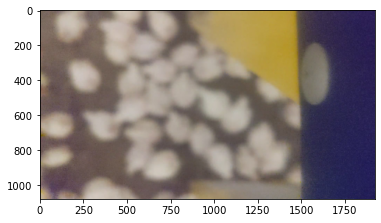

In [14]:
image, value = train_data[0]
# print(image)
to_show = image.permute(1,2,0)
plt.imshow(to_show)

to_test = image.view(1, 3, 1920, 1080)
if torch.cuda.is_available():
    to_test = to_test.cuda()
expected = bird_model(to_test)

def unnormalize(x):
    return (x * average) + std_dev

print(f"Predicted {int(unnormalize(expected))}, Expected : {int(unnormalize(value))}")